In [1]:
import pandas
import datetime
import time
import urllib
import bs4
import os
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
import feather
%matplotlib inline

In [2]:
tecMinCutoff = 10.
delTecCutoff = 0.
delMlatCutoff = 0.

In [3]:
# get dst index vals from wdc kyoto website
# create a list of dates with monthly freq
date_dst_arr = []
dst_val = []
dst_time_del = datetime.timedelta(hours = 1)
start_date = datetime.datetime(2011,1,1)
end_date = datetime.datetime(2014,12,31)
daterange = pandas.date_range(start_date, end_date, freq="M")
for dt in daterange:
    if dt.month <= 9:
            monthStr = "0" + str(dt.month)
    else:
        monthStr = str(dt.month)
    if dt.year >= 2016:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_realtime" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    elif ( (dt.year >= 2014) and (dt.year <= 2015) ):
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_provisional" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    else:
        # create the url
        currUrl = "http://wdc.kugi.kyoto-u.ac.jp/" + "dst_final" + \
            "/" + str(dt.year) + monthStr + "/index.html"
    conn = urllib.urlopen(currUrl)
    htmlSource = conn.read()
    soup = bs4.BeautifulSoup(htmlSource, 'html.parser')
    dataResObj = soup.find("pre", { "class" : "data" })
    # get the data as a list of strings after removing white space
    lines = dataResObj.text.strip().splitlines()
    for line in lines[6:]:
        columns = line.split()
        if len( columns ) > 0. :
            date_dst_arr.append( datetime.datetime( \
                dt.year, dt.month, int(columns[0]), 1 ) )
            for cols in range( len( columns[1:] ) ) :
                try:
                    inNumberFloatTest = float(columns[cols + 1])
                except:
                    # split these cols as well and work on them!
                    try:
                        missedCols = columns[cols + 1].split("-")[1:]
                        if len(missedCols) >= 1:
                            for mcols in missedCols:
                                dst_val.append( -1*float( mcols ) )
                                # now since we added the date earlier we need to be
                                # careful about appending date values
                                if ( len(date_dst_arr) != len(dst_val) ):
                                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
                    except:
                        print "something wrong with messed up vals!-->", columns[cols + 1]
                        continue
                    continue
                # I have to do this because of the messed up way Kyoto puts up the latest dst value..
                # mixed with 9999 (fillers) like if latest dst is 1 then Kyoto puts it as 199999.....
                if len( columns[ cols + 1 ] ) < 5 :
                    dst_val.append( float( columns[ cols + 1 ] ) )
                elif ( len( columns[ cols + 1 ] ) > 5 and columns[ cols + 1 ][0:3] != '999' ) :
                    mixed_messed_dst = ''
                    for jj in range(5) :
                        if columns[ cols + 1 ][jj] != '9' :
                            mixed_messed_dst = mixed_messed_dst + columns[ cols + 1 ][jj]

                    if mixed_messed_dst != '-' :
                        dst_val.append( float( mixed_messed_dst ) )
                    else :
                        dst_val.append( float( 'nan' ) )
                else :
                    dst_val.append( float( 'nan' ) )
                if cols > 0 :
                    date_dst_arr.append ( date_dst_arr[-1] + dst_time_del )
# convert dst data to a dataframe
dstDF = pandas.DataFrame(
    {'dst_date': date_dst_arr,
     'dst_index': dst_val
    })
dstDF["dateStr"] = dstDF["dst_date"].map(lambda x: x.strftime('%Y%m%d'))
dstDF["hour"] = dstDF["dst_date"].map(lambda x: x.strftime('%H'))
dstDF.head()

,dst_date,dst_index,dateStr,hour
0,2011-01-01 01:00:00,-11.0,20110101,01
1,2011-01-01 02:00:00,-11.0,20110101,02
2,2011-01-01 03:00:00,-9.0,20110101,03
3,2011-01-01 04:00:00,-5.0,20110101,04
4,2011-01-01 05:00:00,-3.0,20110101,05


In [4]:
baseDir = "/home/bharat/Documents/code/data/trghBnds/"

colNames = [ "mlatEqu", "tecEqu", "mlon",\
            "mlatPol", "tecPol", "date",\
            "mlatMin", "tecMin", "mlt", "mlonAdjst" ]
frames = []
# cnt = 0
for root, dirs, files in os.walk(baseDir):
    for fNum, fName in enumerate(files):
        currInpLosFile = root + fName
        bndDF = pandas.read_csv(currInpLosFile, delim_whitespace=True,\
                                    header=None, names=colNames,\
                                infer_datetime_format=True,\
                                parse_dates=["date"])
        frames.append( bndDF )

finBndDF = pandas.concat( frames )
finBndDF["normMLT"] = [x-24 if x >= 12 else x\
                         for x in finBndDF['mlt']]
finBndDF["delTecEqu"] = finBndDF["tecEqu"] - finBndDF["tecMin"]
finBndDF["delTecPol"] = finBndDF["tecPol"] - finBndDF["tecMin"]
finBndDF["delMlat"] = finBndDF["mlatPol"] - finBndDF["mlatEqu"]
finBndDF["timeStr"] = finBndDF["date"].dt.strftime('%H%M').astype(int)
# # discard dates where delTecEqu and delTecPol are -ve
# finBndDF["dateStr"] = finBndDF["date"].dt.strftime('%Y%m%d')
discrdDatesDelTec = finBndDF[ (finBndDF["delTecEqu"] < delTecCutoff) |\
                   (finBndDF["delTecPol"] < delTecCutoff) ]["date"].values
finBndDF = finBndDF[ ~finBndDF["date"].isin(discrdDatesDelTec) ].reset_index(drop=True)
# Discard those dates where tecMin is greater than 10.
discrdDatestecMin = finBndDF[ (finBndDF["tecMin"] > tecMinCutoff) ]["date"].values
finBndDF = finBndDF[ ~finBndDF["date"].isin(discrdDatestecMin) ].reset_index(drop=True)
# Discard locations where delMlat < 0.
finBndDF = finBndDF[ finBndDF["delMlat"] > 0. ].reset_index(drop=True)

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2881: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


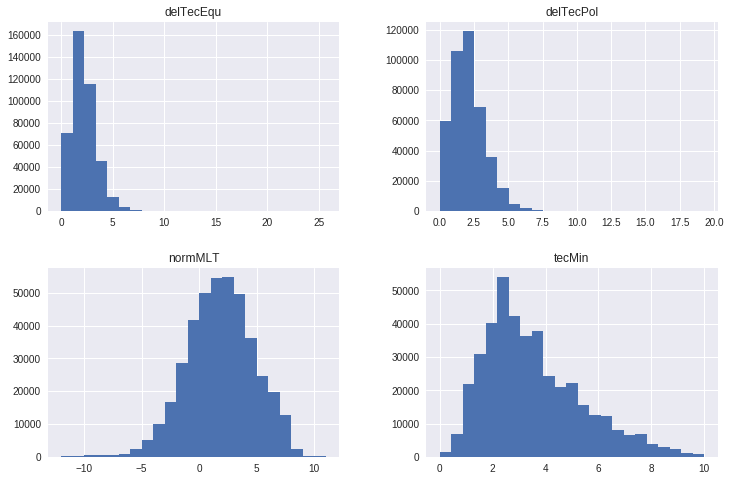

In [5]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
finBndDF.hist(["normMLT", "tecMin", "delTecPol", "delTecEqu"], bins=23, ax=ax)
f.savefig( "../figs/hist-plots.pdf",bbox_inches='tight' )

In [6]:
# finBndDF.shape
# asyDF = pandas.read_csv( "../data/Asy_processed.txt", sep=' ' )
# asyDF["date"] = pandas.to_datetime(asyDF["datetimeStr"], format='%Y%m%d-%H-%M')
finBndDF["dateStr"] = finBndDF["date"].map(lambda x: x.strftime('%Y%m%d'))
finBndDF["hour"] = finBndDF["date"].map(lambda x: x.strftime('%H'))
finBndDF = pandas.merge( finBndDF, dstDF, on=["dateStr", "hour"] )
dstBins = [ -150, -75, -50, -25, -10, 10 ]
finBndDF = pandas.concat( [ finBndDF, \
                    pandas.cut( finBndDF["dst_index"], \
                               bins=dstBins ) ], axis=1 )
finBndDF.columns = ['mlatEqu', 'tecEqu', 'mlon', 'mlatPol', 'tecPol', 'date',
       'mlatMin', 'tecMin', 'mlt', 'mlonAdjst', 'normMLT', 'delTecEqu',
       'delTecPol', 'delMlat', 'timeStr', 'dateStr', 'hour', 'dst_date',
       'dst_index', 'dst_bin']
feather.write_dataframe(finBndDF, '../data/trghBndDst.feather')

In [7]:
# file containing saps data --> date, time, sapsLat, sapsMLT, sapsVel, radId, poesLat, poesMLT
#file_sapsdata = "/Users/bharat/Desktop/saps-north-2011-2012.txt"
file_sapsdata = "../data/rawsaps-north-2011-2014.txt"
# store the data to convert it to DF later
allData = []
# open and read through the file
fs = open(file_sapsdata, 'r')
# only take data from mid-latitude radars
midlatRadIds = [209, 208, 33, 207, 206, 205, 204, 32]
for line in fs:
    line = line.strip()
    columns = line.split()
    
    dt_ind = time.strptime( columns[0], "%Y%m%d" )
    hh_ind = int(int(columns[1])/100)
    mm_ind = int(int(columns[1]) % 100)
    currDt = datetime.datetime( dt_ind.tm_year, dt_ind.tm_mon, dt_ind.tm_mday, hh_ind, mm_ind )
    allData.append( [ columns[0] + "-" + columns[1], currDt, columns[0], \
                     float( columns[2] ), float( columns[3] ), float( columns[4] ), \
                     float( columns[5] ), float( columns[6] ), float( columns[7] ) ] )  
fs.close()
# store data in a DF
sapsRawDF = pandas.DataFrame(allData)
sapsRawDF.columns = [ "dateTimeString", "date", "dateStr", "sapsLat", \
                     "sapsMLT", "sapsVel", "radId", "poesLat", "poesMLT" ]
# count number of unique dates present in the raw DF
uniqRawDates = sapsRawDF["dateStr"].unique().tolist()
print "num of unique(total) dates--->", len(uniqRawDates)
sapsRawDF.head()

num of unique(total) dates---> 1320


,dateTimeString,date,dateStr,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT
0,20110101-100,2011-01-01 01:00:00,20110101,61.5,2.7764,336.5572,10.0,65.4015,3.0
1,20110101-230,2011-01-01 02:30:00,20110101,61.5,4.5593,254.1402,10.0,66.2104,5.0
2,20110101-700,2011-01-01 07:00:00,20110101,54.5,1.7927,639.8867,33.0,67.2811,2.0
3,20110101-700,2011-01-01 07:00:00,20110101,54.5,1.9076,650.9573,33.0,67.2811,2.0
4,20110101-700,2011-01-01 07:00:00,20110101,55.5,1.8949,653.0461,33.0,67.2811,2.0


In [8]:
# create a date string and time column for the dst DF
dstDF["dateStr"] = dstDF["dst_date"].map(lambda x: x.strftime('%Y%m%d'))
dstDF["hour"] = dstDF["dst_date"].map(lambda x: x.strftime('%H'))
# Make an hour column for the sapsRawDF too
sapsRawDF["hour"] = sapsRawDF["date"].map(lambda x: x.strftime('%H'))
# Now merge the dst and sapsRaw DFs
sapsRawDF = pandas.merge( sapsRawDF, dstDF, on=["dateStr", "hour"], how='inner' )
sapsRawDF.head()

,dateTimeString,date,dateStr,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,hour,dst_date,dst_index
0,20110101-100,2011-01-01 01:00:00,20110101,61.5,2.7764,336.5572,10.0,65.4015,3.0,01,2011-01-01 01:00:00,-11.0
1,20110101-230,2011-01-01 02:30:00,20110101,61.5,4.5593,254.1402,10.0,66.2104,5.0,02,2011-01-01 02:00:00,-11.0
2,20110101-700,2011-01-01 07:00:00,20110101,54.5,1.7927,639.8867,33.0,67.2811,2.0,07,2011-01-01 07:00:00,-5.0
3,20110101-700,2011-01-01 07:00:00,20110101,54.5,1.9076,650.9573,33.0,67.2811,2.0,07,2011-01-01 07:00:00,-5.0
4,20110101-700,2011-01-01 07:00:00,20110101,55.5,1.8949,653.0461,33.0,67.2811,2.0,07,2011-01-01 07:00:00,-5.0


In [9]:
# # Try a new method to filter for the SAPS events
# # Involves 3 filters : 
# # 1) get data from only mid-lat radars
sapsRawDF = sapsRawDF[ sapsRawDF["radId"].isin(midlatRadIds) ]
sapsRawDF = sapsRawDF[ sapsRawDF["dst_index"] <= 10.] 
# # 2) The saps event should be observed by atleast 4 mid-latitude radars on a given day
sapsNumRadsSer = sapsRawDF.groupby( ["dateStr"] ).agg( {"radId": pandas.Series.nunique} )
sapsNumRadsSer = sapsNumRadsSer[ sapsNumRadsSer >= 4  ].dropna().reset_index()
sapsNumRadsSer.columns = [ "dateStr", "nRads" ]
# Number of data points on a given date should be greater than 200!
sapsDateTimeCount = sapsRawDF.groupby(["dateStr"]).count()
sapsDateTimeCount = sapsDateTimeCount[ \
                        sapsDateTimeCount["sapsLat"] >= 200 ][ ["dateTimeString"] ].reset_index()
sapsDateTimeCount.columns = [ "dateStr", "nSapsVecs" ]
# Merge both the data points
sapsDateSelDF = pandas.merge( sapsDateTimeCount, sapsNumRadsSer, on="dateStr" )
# Now merge dates selected and saps raw DFs
sapsRawDF = pandas.merge( sapsRawDF, sapsDateSelDF, on="dateStr" )

prcsdSapsDF = sapsRawDF[ ["dateStr", "hour","sapsLat", \
                     "sapsMLT", "sapsVel", "radId", "poesLat", "poesMLT", "dst_date", "dst_index"] ]

prcsdSapsDF["time"] = sapsRawDF["date"].map(lambda x: x.strftime('%H%M'))
# Save to a new model file
feather.write_dataframe(prcsdSapsDF, '../data/processedSaps.feather')
prcsdSapsDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,dateStr,hour,sapsLat,sapsMLT,sapsVel,radId,poesLat,poesMLT,dst_date,dst_index,time
0,20110107,00,56.5,17.7543,308.2077,33.0,62.0082,18.0,2011-01-07,-18.0,0000
1,20110107,00,55.5,18.0147,224.1588,33.0,62.0082,18.0,2011-01-07,-18.0,0000
2,20110107,00,56.5,17.8749,307.4328,33.0,62.0082,18.0,2011-01-07,-18.0,0000
3,20110107,00,55.5,18.1324,222.4787,33.0,62.0082,18.0,2011-01-07,-18.0,0000
4,20110107,00,56.5,17.9955,305.4201,33.0,62.0082,18.0,2011-01-07,-18.0,0000
